In [1]:
from pathlib import Path
import nibabel as nib
import numpy as np
from numpy import pi
from scipy import ndimage
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

from typing import Callable, Union

import torch
from torch import Tensor
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import numpy as np
import matplotlib.pyplot as plt 

import random
from pathlib import Path
from PIL import Image

from operator import itemgetter

import sys
sys.path.append('../src')
from utils import class2one_hot
sys.path.append('..')
from data_augmenter import CTImageDataset, load_ct_images_and_gts, plot_batch

In [17]:
import torch
import pandas as pd

csv_path = '/Users/sachabuijs/Documents/AI4MI/results_metrics/samed/bestweights_samed_512_r6_augment_no_normalize_no_2024-10-08/test_metrics.csv'
data = pd.read_csv(csv_path)
print(data.head())


   Unnamed: 0  patient_id  slice_name      class  metric_type  metric_value
0           0           1           0  Esophagus         Dice           1.0
1           1           1           0      Heart         Dice           1.0
2           2           1           0    Trachea         Dice           1.0
3           3           1           0      Aorta         Dice           1.0
4           4           1           0  Esophagus  Sensitivity           0.0


In [18]:
data['metric_type'].unique()

array(['Dice', 'Sensitivity', 'Specificity', 'Hausdorff', 'IoU',
       'Precision', 'Volumetric', 'VOE'], dtype=object)

In [19]:
data_no_inf = data.replace([np.inf, -np.inf], np.nan)


In [83]:
data_a = pd.read_csv('/Users/sachabuijs/Documents/AI4MI/results_metrics/samed/bestweights_samed_512_r6_augment_yes_normalize_no_2024-10-08/test_metrics.csv')
data_a_no_inf = data_a.replace([np.inf, -np.inf], np.nan)

In [85]:
data_an = pd.read_csv('/Users/sachabuijs/Documents/AI4MI/results_metrics/samed/bestweights_samed_512_r6_augment_yes_normalize_yes_2024-10-08/test_metrics.csv')
data_an_no_inf = data_an.replace([np.inf, -np.inf], np.nan)

## Visualiations of one model

Means of the model

In [61]:
def mean_metric(data):
    plt.figure(figsize=(10, 5))
    data.groupby('metric_type')['metric_value'].mean().plot(kind='bar')
    plt.title('Mean metrics')
    plt.ylabel('Mean Metric Value')
    plt.xlabel('Metric Type')
    plt.show()

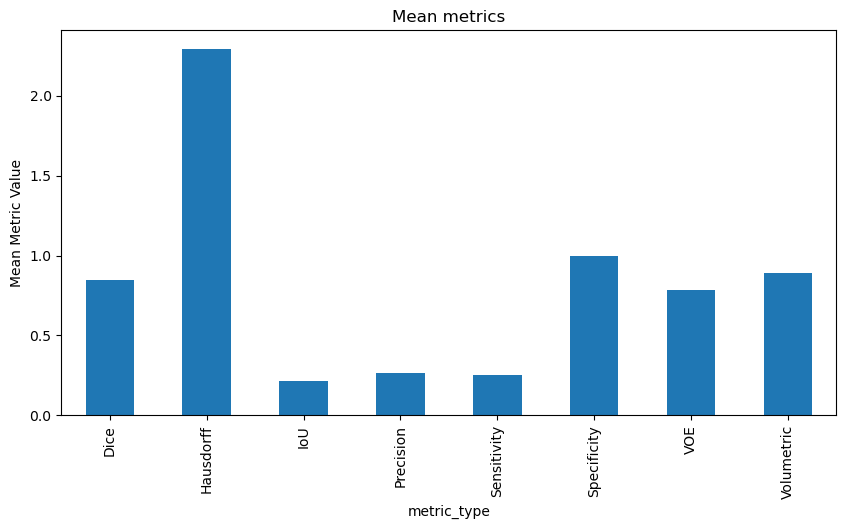

In [60]:
mean_metric(data_no_inf)

Mean scores per class

In [62]:
def mean_metric_per_class(data):
    plt.figure(figsize=(10, 5))
    data.groupby(['metric_type', 'class'])['metric_value'].mean().unstack().plot(kind='bar')
    plt.ylabel('Mean Metric Value')
    plt.xlabel('Metric Type')

    plt.title('Mean Metric Value by Metric Type and Class')
    plt.show()

<Figure size 1000x500 with 0 Axes>

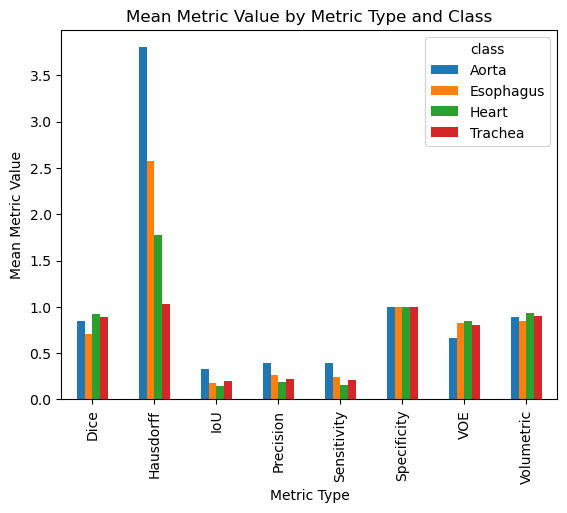

In [63]:
mean_metric_per_class(data_no_inf)

How many inf values per class

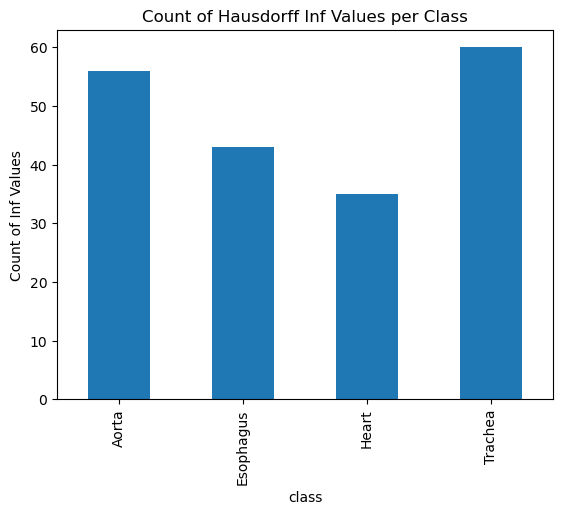

In [64]:
hausdorff_data = data[data['metric_type'] == 'Hausdorff']
inf_counts_per_class = data[data['metric_value']== np.inf].groupby('class')['metric_value'].count()
inf_counts_per_class.head()
inf_counts_per_class.plot(kind='bar')
plt.ylabel('Count of Inf Values')
plt.title('Count of Hausdorff Inf Values per Class')
plt.show()

Distibution of values per class

In [51]:
def distribution_of_metric(data, metric_type):
    plt.figure(figsize=(10, 5))
    data[data['metric_type'] == metric_type]['metric_value'].hist(bins=50)
    plt.xlabel(f'{metric_type}')
    plt.ylabel('Count')
    plt.title(f'Distribution of {metric_type} Values')
    plt.show()

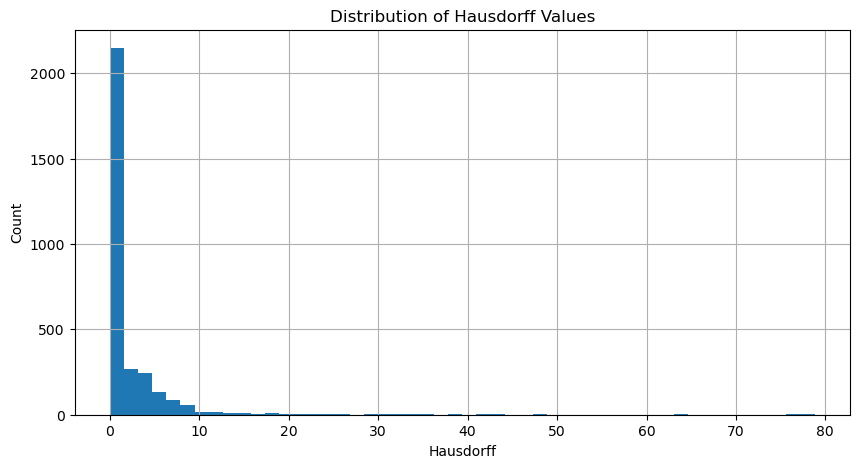

In [65]:
distribution_of_metric(data_no_inf, 'Hausdorff')

In [57]:
def distribution_of_metric_per_class(data, metric_type):
    plt.figure(figsize=(10, 5))
    
    sns.boxplot(x='class', y='metric_value', data=data[data['metric_type'] == metric_type])
    plt.xlabel('Class')
    plt.ylabel(f'{metric_type}')
    plt.title(f'Distribution of {metric_type} Values')
    plt.show()

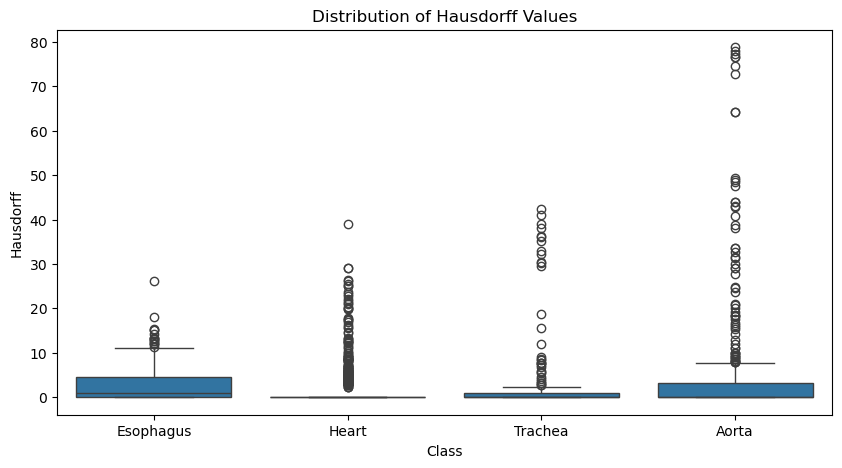

In [66]:
distribution_of_metric_per_class(data_no_inf, 'Hausdorff')

## Comparison of models

Mean metrics for multiple models

In [81]:
def mean_metric_comparison(datasets: list, dataset_names: list):
    num_datasets = len(datasets)
    combined_data = pd.concat([data.assign(Dataset=f'{dataset_names[i]}') for i, data in enumerate(datasets)])
    
    plt.figure(figsize=(10, 5))
    combined_data.groupby(['metric_type', 'Dataset'])['metric_value'].mean().unstack().plot(kind='bar')
    
    plt.title('Mean metrics for multiple datasets')
    plt.ylabel('Mean Metric Value')
    plt.xlabel('Metric Type')
    plt.show()

<Figure size 1000x500 with 0 Axes>

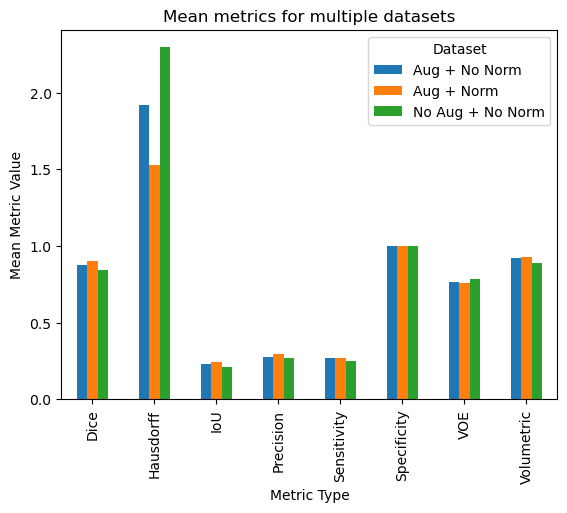

In [86]:
mean_metric_comparison([data_no_inf, data_a_no_inf, data_an_no_inf], ['No Aug + No Norm', 'Aug + No Norm', 'Aug + Norm'])

comparison of multple models for all metrics and all classes

In [87]:
def metric_comparison_per_class(datasets: list, dataset_names: list):
    num_datasets = len(datasets)
    combined_data = pd.concat([data.assign(Dataset=f'{dataset_names[i]}') for i, data in enumerate(datasets)])
    
    plt.figure(figsize=(10, 5))
    combined_data.groupby(['metric_type', 'class', 'Dataset'])['metric_value'].mean().unstack().plot(kind='bar')
    
    plt.title('Mean metrics for multiple datasets')
    plt.ylabel('Mean Metric Value')
    plt.xlabel('Metric Type')
    plt.show()

<Figure size 1000x500 with 0 Axes>

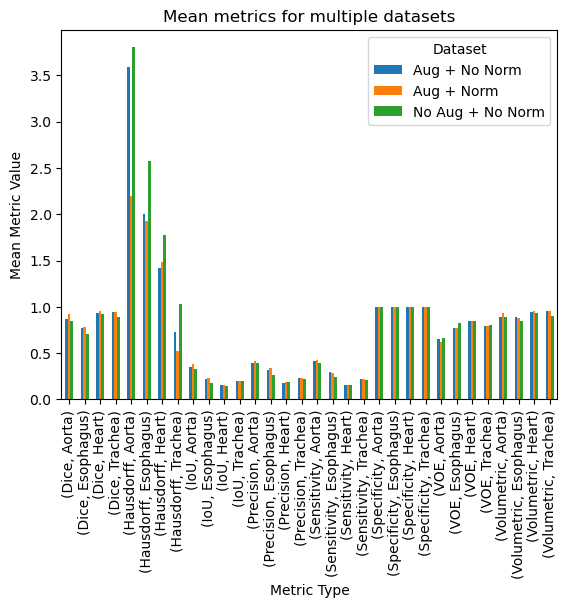

In [88]:
metric_comparison_per_class([data_no_inf, data_a_no_inf, data_an_no_inf], ['No Aug + No Norm', 'Aug + No Norm', 'Aug + Norm'])

comparison of multple models for one metrics and all classes

In [100]:
def one_metric_comparison_per_class(datasets: list, dataset_names: list, metric_type: str):
    num_datasets = len(datasets)
    combined_data = pd.concat([data.assign(Dataset=f'{dataset_names[i]}') for i, data in enumerate(datasets)])
    
    plt.figure(figsize=(10, 5))
    metric_data = combined_data[combined_data['metric_type'] == metric_type]
    metric_data.groupby(['class', 'Dataset'])['metric_value'].mean().unstack().plot(kind='bar')
    
    plt.title(f'Mean {metric_type} for multiple datasets')
    plt.ylabel('Mean Metric Value')
    plt.xlabel('Class')
    plt.show()

<Figure size 1000x500 with 0 Axes>

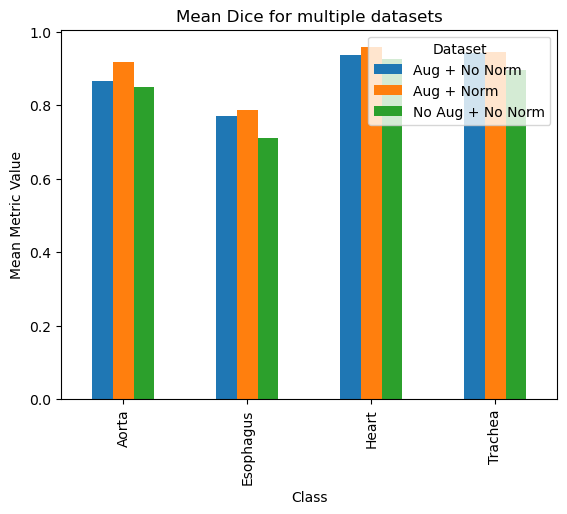

In [102]:


one_metric_comparison_per_class([data_no_inf, data_a_no_inf, data_an_no_inf], ['No Aug + No Norm', 'Aug + No Norm', 'Aug + Norm'], 'Dice')